# 正态性检验和蒙特卡洛完成投资组合优化


最近一直在思考怎样有效的配置资产组合。
很多时候根据条件选好股票池之后，通常简单粗暴的等分仓位给每只股票。
其实，这个过程中有很多可以优化的空间。

下面，给大家分享一下如何运用**有效前沿**进行资产组合优化。

## PART ONE: 正态性检验


### **1.导入模块**

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
import tushare as ts
%matplotlib inline

### **2.选取几只感兴趣的股票。**

002697 红旗连锁,
600783 鲁信创投,
000413 东旭光电,
601588 北辰实业

In [2]:
stock = ["hs300etf", "bond", "hs300"] # ['510300','510010','hs300']
hs300etf_htbr = ts.get_hist_data("510300", "2016-04-28")  # 沪市 华泰柏瑞沪深300ETF ETF-场内 *
bond_y5gz_etf = ts.get_hist_data("511210", "2016-04-28")  # 国泰上证5年期国债ETF（511010）*
hs300 = ts.get_hist_data('510220', "2016-04-28")  # 获取沪深300指数k线数据

data = pd.concat([hs300etf_htbr["close"], bond_y5gz_etf["close"], hs300['close']], axis=1)
data.columns = ["hs300etf", "bond", "hs300"]
data.head()

hs300etf   bond  hs300
2016-04-28      3.16  113.3   3.67
2016-04-29      3.15  113.2   3.67
2016-05-03      3.21  113.4   3.68
2016-05-04      3.20  113.5   3.70
2016-05-05      3.20  113.5   3.70

### **3.比较一下机制股票的情况。规范起点为100.**

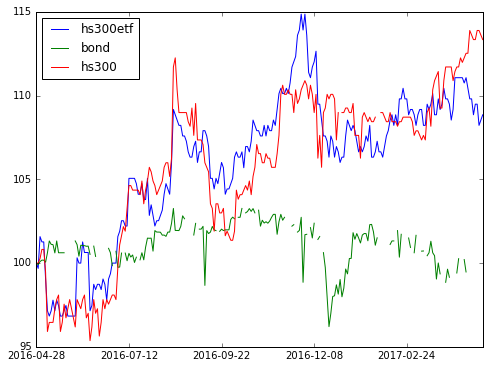

In [3]:

(data/data.ix[0]*100).plot(figsize = (8,6))

### **4.计算收益率**

用pandas计算收益率会比Numpy效率高一些，可以用shift方法

In [4]:
log_returns = np.log(data/data.shift(1))
log_returns.head()

hs300etf      bond     hs300
2016-04-28       NaN       NaN       NaN
2016-04-29 -0.003170 -0.000883  0.000000
2016-05-03  0.018868  0.001765  0.002721
2016-05-04 -0.003120  0.000881  0.005420
2016-05-05  0.000000  0.000000  0.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000003D589E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000CCA90B8>]], dtype=object)

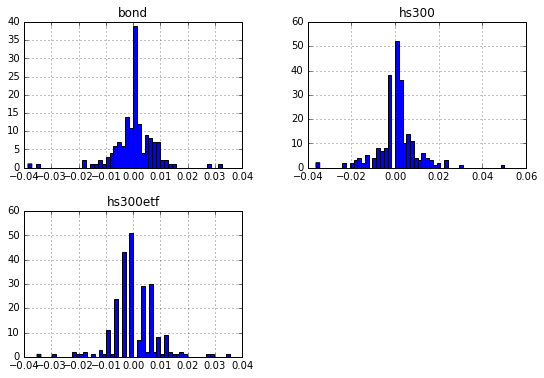

In [5]:
log_returns.hist(bins = 50, figsize = (9,6))

从以上结果看到4个数据集都和正态分布的要求相差太多。

### **5.输出每只股票的统计数据**

In [6]:
#定义print_statistics函数，为了更加易于理解的方式
#输出给定(历史或者模拟)数据集均值、偏斜度或者峰度等统计数字
def print_statistics(array):
    sta = scs.describe(array)
    print '%14s %15s' %('statistic','value')
    print 30*'-'
    print '%14s %15d' %('size', sta[0])
    print '%14s %15.5f' %('min', sta[1][0])
    print '%14s %15.5f' %('max', sta[1][1])
    print '%14s %15.5f' %('mean', sta[2])
    print '%14s %15.5f' %('std', np.sqrt(sta[3]))
    print '%14s %15.5f' %('skew', sta[4])
    print '%14s %15.5f' %('kurtosis', sta[5])

for st in stock:
    print '\nResults for stock %s' %st
    print 30*'-'
    log_data = np.array(log_returns[st].dropna())
    print_statistics(log_data)


Results for stock hs300etf
------------------------------
     statistic           value
------------------------------
          size             241
           min        -0.03520
           max         0.03532
          mean         0.00035
           std         0.00805
          skew        -0.03109
      kurtosis         3.97712

Results for stock bond
------------------------------
     statistic           value
------------------------------
          size             154
           min        -0.03853
           max         0.03265
          mean         0.00018
           std         0.00797
          skew        -0.71794
      kurtosis         7.14477

Results for stock hs300
------------------------------
     statistic           value
------------------------------
          size             236
           min        -0.03627
           max         0.05001
          mean         0.00052
           std         0.00932
          skew         0.22265
      kurtosis         4

### **6.画qq图观察数据**

下面是002697.XSHE 对数收益率 分位数-分位数图


Results for stock hs300etf


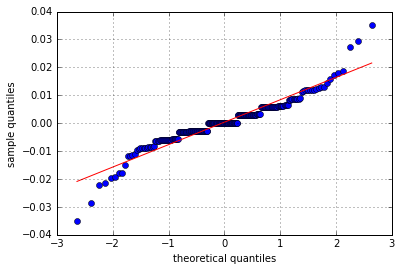


Results for stock bond


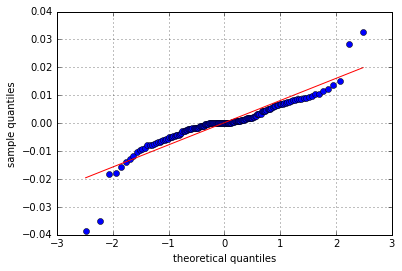


Results for stock hs300


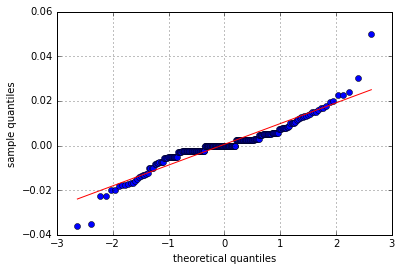

In [7]:
for st in stock:
    print '\nResults for stock %s' %st
    sm.qqplot(log_returns[st].dropna(),line = 's')
    plt.grid(True)
    plt.xlabel('theoretical quantiles')
    plt.ylabel('sample quantiles')
    plt.show()

很显然，样本的分位数值不在一条直线上，表明“非正态性”。左侧和右侧分别有许多值远低于和远高于直线。这是典型的Fat tails。 Fat tails是频数分布中观察到的两端的异常值。

### **7.进行正态性检验**

In [8]:
def normality_test(array):
    '''
    对给定的数据集进行正态性检验
    组合了3中统计学测试
    偏度测试（Skewtest）——足够接近0
    峰度测试（Kurtosistest)——足够接近0
    正态性测试
    '''
    print 'Skew of data set %15.3f' % scs.skew(array)
    print 'Skew test p-value %14.3f' % scs.skewtest(array)[1]
    print 'Kurt of data set %15.3f' % scs.kurtosis(array)
    print 'Kurt test p-value %14.3f' % scs.kurtosistest(array)[1]
    print 'Norm test p-value %14.3f' % scs.normaltest(array)[1]

for st in stock:
    print '\nResults for st %s' %st
    print 32*'-'
    log_data = np.array(log_returns[st].dropna())
    normality_test(log_data)


Results for st hs300etf
--------------------------------
Skew of data set          -0.031
Skew test p-value          0.839
Kurt of data set           3.977
Kurt test p-value          0.000
Norm test p-value          0.000

Results for st bond
--------------------------------
Skew of data set          -0.718
Skew test p-value          0.001
Kurt of data set           7.145
Kurt test p-value          0.000
Norm test p-value          0.000

Results for st hs300
--------------------------------
Skew of data set           0.223
Skew test p-value          0.155
Kurt of data set           4.960
Kurt test p-value          0.000
Norm test p-value          0.000


从上述测试的p值来看，否定了数据集呈正态分布的测试假设。
这说明，**股票市场收益率的正态假设不成立**。

---

## PART TWO：均值-方差投资组合理论

该理论基于用均值和方差来表述组合的优劣的前提。将选取几只股票，用蒙特卡洛模拟初步探究组合的有效前沿。

通过最大Sharpe和最小方差两种优化来找到最优的资产组合配置权重参数。

最后，刻画出可能的分布，两种最优以及组合的有效前沿。

### **1.选取几只感兴趣的股票**

000413 东旭光电，000063 中兴通讯，002007 华兰生物，000001 平安银行，000002 万科A

并比较一下数据（2015-01-01至2015-12-31）

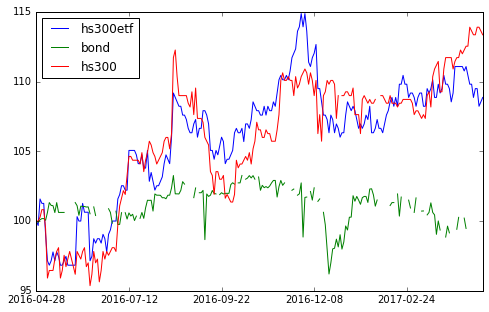

In [9]:
stock_set = stock
noa = len(stock_set)

#规范化后时序数据
(data/data.ix[0]*100).plot(figsize = (8,5))

### **2.计算不同证券的均值、协方差**

每年252个交易日，用每日收益得到年化收益。

计算投资资产的协方差是构建资产组合过程的核心部分。运用pandas内置方法生产协方差矩阵。

In [10]:
returns = np.log(data / data.shift(1))
returns.mean()*252 # 252个交易日

hs300etf    0.088775
bond        0.044931
hs300       0.131147
dtype: float64

In [11]:
returns.cov()*252

hs300etf      bond     hs300
hs300etf  0.016342  0.002302  0.008503
bond      0.002302  0.015996  0.001014
hs300     0.008503  0.001014  0.021870

### **3.给不同资产随机分配初始权重**

由于A股不允许建立空头头寸，所有的权重系数均在0-1之间

In [12]:
# weights standard
weights = np.random.random(noa)
weights /= np.sum(weights)
print weights
print np.sum(weights)

[ 0.1816009   0.40005482  0.41834428]
1.0


### **4.计算预期组合年化收益、组合方差和组合标准差**

####  4.1 Portfolio Return
$$ R_p = \Sigma_{i=1}^{N}w_{i}R_{i}$$


In [13]:
# 预期组合年化收益
np.sum(returns.mean()*weights)*252

0.08896089650103954

#### 4.2 Portfolio Risk
weights.T * 协方差阵 * weights

In [14]:
# measures of riskiness of returns 组合方差
np.dot(weights.T, np.dot(returns.cov()*252,weights))

0.0088924937227731933

In [15]:
np.sqrt(np.dot(weights.T, np.dot(returns.cov()* 252,weights)))

0.094300019738986232

### **5.用蒙特卡洛模拟产生大量随机组合**

进行到此，我们最想知道的是给定的一个股票池（证券组合）如何找到风险和收益平衡的位置。

下面通过一次蒙特卡洛模拟，产生大量随机的权重向量，并记录随机组合的预期收益和方差。

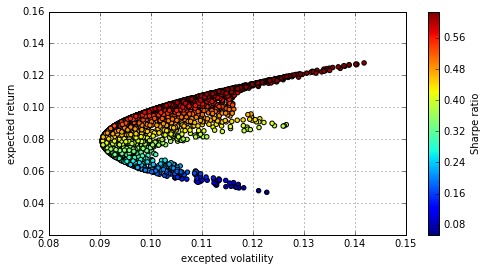

In [16]:
port_returns = []
port_variance = []
for p in range(4000):
    weights = np.random.random(noa)
    weights /=np.sum(weights)
    port_returns.append(np.sum(returns.mean()*252*weights))
    port_variance.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights))))

port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

#无风险利率设定为4%
risk_free = 0.04
plt.figure(figsize = (8,4))
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker = 'o')
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

### **6.投资组合优化1——sharpe最大**

建立statistics函数来记录重要的投资组合统计数据（收益，方差和夏普比）

通过对约束最优问题的求解，得到最优解。其中约束是权重总和为1。

In [17]:
def statistics(weights):
    weights = np.array(weights)
    port_returns = np.sum(returns.mean()*weights)*252
    port_variance = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252,weights)))
    return np.array([port_returns, port_variance, port_returns/port_variance])

#最优化投资组合的推导是一个约束最优化问题
import scipy.optimize as sco

#最小化夏普指数的负值
def min_sharpe(weights):
    return -statistics(weights)[2]

#约束是所有参数(权重)的总和为1。这可以用minimize函数的约定表达如下
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})

#我们还将参数值(权重)限制在0和1之间。这些值以多个元组组成的一个元组形式提供给最小化函数
bnds = tuple((0,1) for x in range(noa))

#优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
opts = sco.minimize(min_sharpe, noa*[1./noa,], method = 'SLSQP', bounds = bnds, constraints = cons)
opts

     fun: -0.98326427998487897
     jac: array([-0.00031127, -0.00138508,  0.00076313,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ 0.26933123,  0.22134589,  0.50932288])

得到的最优组合**权重向量**为：

In [18]:
opts['x'].round(3)

array([ 0.269,  0.221,  0.509])

sharpe最大的组合3个**统计数据**分别为：

In [19]:
#预期收益率、预期波动率、最优夏普指数
statistics(opts['x']).round(3)

array([ 0.101,  0.102,  0.983])

### **7.投资组合优化2——方差最小**

接下来，我们通过方差最小来选出最优投资组合。

In [20]:
#但是我们定义一个函数对 方差进行最小化
def min_variance(weights):
    return statistics(weights)[1]

optv = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
optv

     fun: 0.090523810035774824
     jac: array([ 0.08992639,  0.0906675 ,  0.09104201,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([ 0.31232442,  0.45329065,  0.23438493])

方差最小的最优组合**权重向量**及**组合的统计数据**分别为：

In [21]:
optv['x'].round(3)

array([ 0.312,  0.453,  0.234])

In [22]:
#得到的预期收益率、波动率和夏普指数
statistics(optv['x']).round(3)

array([ 0.079,  0.091,  0.871])

### **8.组合的有效前沿**

有效前沿有既定的目标收益率下方差最小的投资组合构成。

在最优化时采用两个约束，1.给定目标收益率，2.投资组合权重和为1。

In [23]:
def min_variance(weights):
    return statistics(weights)[1]

#在不同目标收益率水平（target_returns）循环时，最小化的一个约束条件会变化。
target_returns = np.linspace(0.0,0.5,50)
target_variance = []
for tar in target_returns:
    cons = ({'type':'eq','fun':lambda x:statistics(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
    target_variance.append(res['fun'])

target_variance = np.array(target_variance)

下面是最优化结果的展示。

**叉号**：构成的曲线是有效前沿（目标收益率下最优的投资组合）

**红星**：sharpe最大的投资组合

**黄星**：方差最小的投资组合

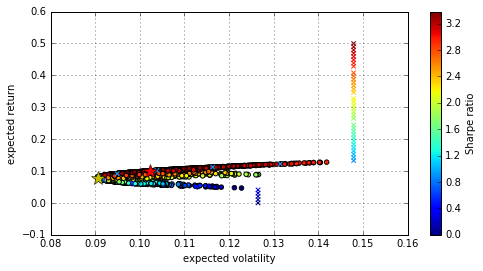

In [24]:
plt.figure(figsize = (8,4))
#圆圈：蒙特卡洛随机产生的组合分布
plt.scatter(port_variance, port_returns, c = port_returns/port_variance,marker = 'o')
#叉号：有效前沿
plt.scatter(target_variance,target_returns, c = target_returns/target_variance, marker = 'x')
#红星：标记最高sharpe组合
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize = 15.0)
#黄星：标记最小方差组合
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize = 15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')